# Support Vector Machine (SVM) Model


In [1]:
# Uncomment to get the correct versions
from IPython.display import clear_output
!pip install -r ../requirements.txt
clear_output() 


In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score



In [3]:
# Get the data

x_train_path = '../../data/train_test_split/x_train_cluster.csv'
y_train_path = '../../data/train_test_split/y_train.csv'

x_test_path = '../../data/train_test_split/x_test_cluster.csv'
y_test_path = '../../data/train_test_split/y_test.csv'

x_train_df = pd.read_csv(x_train_path) 
y_train_df = pd.read_csv(y_train_path) 

x_test_df = pd.read_csv(x_test_path)
y_test_df = pd.read_csv(y_test_path)



In [4]:
# Combine train and test
train_df = pd.merge(x_train_df, y_train_df, how='left', left_index=True, right_index=True)
test_df = pd.merge(x_test_df, y_test_df,how='left', left_index=True, right_index=True)

In [5]:
train_df.head() 

,Unnamed: 0.1,name,rating,ranking,year,position,height,weight,latitude,longitude,...,point_diff_rolling_2year,win_pct_rolling_2year,distance_miles,side_of_ball,position_group,DBSCAN_Cluster_PCA,SVD_KMeans_Cluster,KMeans_Cluster,Unnamed: 0,is_drafted
0,361,C.J. Prosise,0.8915,365.0,2012,S,74.0,190.0,35.166812,-80.751458,...,190.0,0.615385,539.828641,defense,d_backfield,0,1,2,361,1.0
1,14685,Jaylon Haynes,0.8166,1684.0,2017,DT,73.0,290.0,29.312480,-96.098238,...,-118.0,0.360000,143.529399,defense,d_line,0,3,1,14685,0.0
2,15617,Nasser Clark,0.7667,3299.0,2017,RB,70.0,190.0,34.597245,-83.763306,...,62.0,0.400000,709.669019,offense,running_back,1,3,0,15617,0.0
3,3870,Courtney Miggins,0.8111,1568.0,2013,SDE,77.0,240.0,33.712331,-84.105194,...,128.0,0.692308,523.980272,defense,d_line,0,1,1,3870,0.0
4,20038,Zaylin Wood,0.8383,1429.0,2019,SDE,74.0,262.0,33.537889,-85.253282,...,29.0,0.555556,171.919819,defense,d_line,0,1,1,20038,0.0


In [6]:
# Convert all the clusters into objects
train_df['KMeans_Cluster'] = train_df['KMeans_Cluster'].astype(object)
test_df['KMeans_Cluster'] = test_df['KMeans_Cluster'].astype(object)

train_df['SVD_KMeans_Cluster'] = train_df['SVD_KMeans_Cluster'].astype(object)
test_df['SVD_KMeans_Cluster'] = test_df['SVD_KMeans_Cluster'].astype(object)

train_df['DBSCAN_Cluster_PCA'] = train_df['DBSCAN_Cluster_PCA'].astype(object)
test_df['DBSCAN_Cluster_PCA'] = test_df['DBSCAN_Cluster_PCA'].astype(object)

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
# Display the Target rates of the training and testing datast 
print('Training Conversion Rate: ', round(train_df['is_drafted'].mean(),4)* 100.0, '%')
print('Testing Conversion Rate: ', round(test_df['is_drafted'].mean(),4) * 100.0, '%')



Training Conversion Rate:  8.62 %
Testing Conversion Rate:  8.24 %


In [9]:
numerical_features = ['rating', 'ranking', 'height', 'weight', 'distance_miles', 'stars', 'games_played_rolling_2year','win_pct_rolling_2year']

# numerical_features = ['games_played_rolling_2year']
clusters = ['KMeans_Cluster', 'SVD_KMeans_Cluster', 'DBSCAN_Cluster_PCA']
categorical_features = ['position_group',  'state_province', 'side_of_ball']


features = numerical_features+clusters+categorical_features
target = ['is_drafted']


In [10]:
# Separate features and target in the balanced dataset
X = train_df[features]
y = train_df[target]


### Pre-process the data

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features+clusters)
    ])

In [12]:
X_train = preprocessor.fit_transform(X)

X_test = test_df[features]
X_test_processed = preprocessor.transform(X_test)


In [13]:
y_train = y
y_test = test_df[['is_drafted']]

### Hyperparameter Tuning

In [15]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.1 MB/s eta 0:00:00


In [17]:
from skopt import BayesSearchCV
from sklearn.svm import SVC
from skopt.space import Real, Categorical, Integer

# Define the search space
search_space = {
    'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
    'C': Real(1e-3, 1e3, prior='log-uniform'),  # Log-uniform for scaling
    'gamma': Real(1e-3, 1e1, prior='log-uniform'),  # Only used for 'rbf', 'poly', and 'sigmoid' kernels
    'degree': Integer(2, 5)  # Only relevant for 'poly' kernel
}

# Initialize the SVC model
svm_model = SVC(class_weight='balanced', random_state=42)

# Bayesian optimization with 5-fold cross-validation
opt = BayesSearchCV(estimator=svm_model, search_spaces=search_space, 
                    scoring='f1', n_iter=30, cv=5, n_jobs=-1, random_state=42)

# Fit the optimizer to the training data
opt.fit(X_train, y_train)

# Get the best parameters and score
best_params = opt.best_params_
best_score = opt.best_score_

clear_output()
print("Best hyperparameters:", best_params)
print(f"Best cross-validated F1 score: {best_score:.4f}")


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py

KeyboardInterrupt: 

In [14]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# # Define hyperparameter grid
# param_grid = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'C': [0.1, 1, 10, 100],  # Regularization parameter
#     'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient for non-linear kernels
#     'degree': [2, 3, 4, 5]  # Degree for 'poly' kernel
# }

# # Initialize SVC with class weight balancing
# svm_model = SVC(class_weight='balanced', random_state=42)

# # Perform grid search with 5-fold cross-validation
# grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, 
#                            scoring='f1', cv=5, verbose=2, n_jobs=-1)

# # Fit grid search to training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# clear_output() 

# print("Best hyperparameters:", best_params)
# print(f"Best cross-validated F1 score: {best_score:.4f}")

# # Optional: Extract all the results
# cv_results = grid_search.cv_results_
# results_df = pd.DataFrame(cv_results)

# # Display the results
# results_df = results_df[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')
# print("All cross-validation results:")
# print(results_df)



Fitting 5 folds for each of 384 candidates, totalling 1920 fits


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py

[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  22.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  23.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  24.6s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  24.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  21.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=  26.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=  26.5s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=  26.5s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=  24.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=  24.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=  28.0s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=  28.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=2, gamma=scale, kernel=sigmoid; total time=  16.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=  28.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=  27.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=  28.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=2, gamma=scale, kernel=sigmoid; total time=  17.5s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=2, gamma=scale, kernel=sigmoid; total time=  18.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=2, gamma=scale, kernel=sigmoid; total time=  17.5s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=2, gamma=scale, kernel=sigmoid; total time=  17.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=auto, kernel=linear; total time=  20.5s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=auto, kernel=linear; total time=  23.5s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=auto, kernel=linear; total time=  23.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=auto, kernel=linear; total time=  22.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=auto, kernel=linear; total time=  22.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=auto, kernel=poly; total time=  29.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=auto, kernel=poly; total time=  29.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=auto, kernel=poly; total time=  30.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=auto, kernel=poly; total time=  29.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=auto, kernel=poly; total time=  28.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=auto, kernel=rbf; total time=  28.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=auto, kernel=rbf; total time=  27.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=auto, kernel=rbf; total time=  28.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=auto, kernel=rbf; total time=  28.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=auto, kernel=rbf; total time=  29.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=auto, kernel=sigmoid; total time=  25.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=auto, kernel=sigmoid; total time=  25.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=auto, kernel=sigmoid; total time=  26.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=auto, kernel=sigmoid; total time=  26.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=auto, kernel=sigmoid; total time=  26.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=0.001, kernel=linear; total time=  22.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=0.001, kernel=linear; total time=  20.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=0.001, kernel=linear; total time=  22.6s
[CV] END ........C=0.1, degree=2, gamma=0.001, kernel=linear; total time=  21.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=0.001, kernel=linear; total time=  20.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=2, gamma=0.001, kernel=poly; total time=  32.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=2, gamma=0.001, kernel=poly; total time=  33.7s
[CV] END ..........C=0.1, degree=2, gamma=0.001, kernel=poly; total time=  33.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=2, gamma=0.001, kernel=poly; total time=  33.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=2, gamma=0.001, kernel=poly; total time=  31.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=0.001, kernel=rbf; total time=  31.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=0.001, kernel=rbf; total time=  31.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=0.001, kernel=rbf; total time=  31.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=0.001, kernel=rbf; total time=  32.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=2, gamma=0.001, kernel=sigmoid; total time=  29.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=0.001, kernel=rbf; total time=  31.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=2, gamma=0.001, kernel=sigmoid; total time=  28.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=2, gamma=0.001, kernel=sigmoid; total time=  29.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=0.01, kernel=linear; total time=  23.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=2, gamma=0.001, kernel=sigmoid; total time=  29.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=2, gamma=0.001, kernel=sigmoid; total time=  29.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=0.01, kernel=linear; total time=  20.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=0.01, kernel=linear; total time=  23.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=0.01, kernel=linear; total time=  21.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=0.01, kernel=linear; total time=  21.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=0.01, kernel=poly; total time=  30.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=0.01, kernel=poly; total time=  30.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=0.01, kernel=poly; total time=  31.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=0.01, kernel=poly; total time=  30.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=0.01, kernel=poly; total time=  29.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=0.01, kernel=rbf; total time=  30.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=0.01, kernel=rbf; total time=  29.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=0.01, kernel=rbf; total time=  30.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=0.01, kernel=rbf; total time=  28.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=0.01, kernel=sigmoid; total time=  25.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=0.01, kernel=sigmoid; total time=  26.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=0.01, kernel=rbf; total time=  30.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=0.01, kernel=sigmoid; total time=  27.5s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=2, gamma=0.1, kernel=linear; total time=  23.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=0.01, kernel=sigmoid; total time=  27.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=2, gamma=0.01, kernel=sigmoid; total time=  27.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=2, gamma=0.1, kernel=linear; total time=  21.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=2, gamma=0.1, kernel=linear; total time=  23.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=2, gamma=0.1, kernel=linear; total time=  22.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=2, gamma=0.1, kernel=linear; total time=  22.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=0.1, kernel=poly; total time=  25.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=0.1, kernel=poly; total time=  24.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=0.1, kernel=poly; total time=  24.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=0.1, kernel=poly; total time=  24.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=0.1, kernel=poly; total time=  24.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .............C=0.1, degree=2, gamma=0.1, kernel=rbf; total time=  28.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .............C=0.1, degree=2, gamma=0.1, kernel=rbf; total time=  28.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .............C=0.1, degree=2, gamma=0.1, kernel=rbf; total time=  29.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=0.1, kernel=sigmoid; total time=  16.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=0.1, kernel=sigmoid; total time=  17.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .............C=0.1, degree=2, gamma=0.1, kernel=rbf; total time=  29.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .............C=0.1, degree=2, gamma=0.1, kernel=rbf; total time=  29.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=0.1, kernel=sigmoid; total time=  18.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=0.1, kernel=sigmoid; total time=  17.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=2, gamma=0.1, kernel=sigmoid; total time=  17.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=  22.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=  20.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=  21.7s
[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=  22.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=  20.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=  38.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=  37.5s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=  40.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=  37.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=  33.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=  36.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=  33.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=  33.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=1, kernel=sigmoid; total time=  30.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=  33.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=  33.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=1, kernel=sigmoid; total time=  27.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=1, kernel=sigmoid; total time=  19.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=1, kernel=sigmoid; total time=  25.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=scale, kernel=linear; total time=  22.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=scale, kernel=linear; total time=  20.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=scale, kernel=linear; total time=  22.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=2, gamma=1, kernel=sigmoid; total time=  48.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=scale, kernel=linear; total time=  21.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=scale, kernel=linear; total time=  21.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=scale, kernel=poly; total time=  26.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=scale, kernel=poly; total time=  27.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=scale, kernel=poly; total time=  27.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=scale, kernel=poly; total time=  26.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=scale, kernel=poly; total time=  24.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=scale, kernel=rbf; total time=  29.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=scale, kernel=rbf; total time=  29.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=scale, kernel=rbf; total time=  29.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=3, gamma=scale, kernel=sigmoid; total time=  16.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=scale, kernel=rbf; total time=  28.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=scale, kernel=rbf; total time=  28.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=3, gamma=scale, kernel=sigmoid; total time=  18.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=3, gamma=scale, kernel=sigmoid; total time=  17.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=3, gamma=scale, kernel=sigmoid; total time=  17.5s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=3, gamma=scale, kernel=sigmoid; total time=  17.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=3, gamma=auto, kernel=linear; total time=  22.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=3, gamma=auto, kernel=linear; total time=  20.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=3, gamma=auto, kernel=linear; total time=  23.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=3, gamma=auto, kernel=linear; total time=  21.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=3, gamma=auto, kernel=linear; total time=  21.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=auto, kernel=poly; total time=  31.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=auto, kernel=poly; total time=  31.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=auto, kernel=poly; total time=  31.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=auto, kernel=poly; total time=  31.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=auto, kernel=poly; total time=  30.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=auto, kernel=rbf; total time=  29.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=auto, kernel=rbf; total time=  28.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=auto, kernel=rbf; total time=  29.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=auto, kernel=rbf; total time=  29.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=auto, kernel=sigmoid; total time=  26.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=auto, kernel=rbf; total time=  30.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=auto, kernel=sigmoid; total time=  26.5s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=auto, kernel=sigmoid; total time=  27.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=auto, kernel=sigmoid; total time=  26.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=auto, kernel=sigmoid; total time=  26.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=0.001, kernel=linear; total time=  22.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=0.001, kernel=linear; total time=  20.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=0.001, kernel=linear; total time=  21.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=0.001, kernel=linear; total time=  23.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=0.001, kernel=linear; total time=  21.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=0.001, kernel=poly; total time=  32.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=0.001, kernel=poly; total time=  32.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=0.001, kernel=poly; total time=  32.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=0.001, kernel=poly; total time=  33.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=0.001, kernel=poly; total time=  32.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=0.001, kernel=rbf; total time=  31.5s
[CV] END ...........C=0.1, degree=3, gamma=0.001, kernel=rbf; total time=  32.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=0.001, kernel=rbf; total time=  31.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=0.001, kernel=rbf; total time=  31.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=3, gamma=0.001, kernel=sigmoid; total time=  28.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=3, gamma=0.001, kernel=sigmoid; total time=  28.5s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=0.001, kernel=rbf; total time=  31.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=3, gamma=0.001, kernel=sigmoid; total time=  29.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=3, gamma=0.01, kernel=linear; total time=  22.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=3, gamma=0.001, kernel=sigmoid; total time=  29.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, degree=3, gamma=0.001, kernel=sigmoid; total time=  29.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=3, gamma=0.01, kernel=linear; total time=  20.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=3, gamma=0.01, kernel=linear; total time=  22.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=3, gamma=0.01, kernel=linear; total time=  21.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, degree=3, gamma=0.01, kernel=linear; total time=  21.5s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=0.01, kernel=poly; total time=  40.2s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=0.01, kernel=poly; total time=  40.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=0.01, kernel=poly; total time=  40.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=0.01, kernel=poly; total time=  39.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, degree=3, gamma=0.01, kernel=poly; total time=  34.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=0.01, kernel=rbf; total time=  32.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=0.01, kernel=rbf; total time=  33.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=0.01, kernel=rbf; total time=  34.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=0.01, kernel=rbf; total time=  31.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=0.01, kernel=sigmoid; total time=  27.8s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=0.01, kernel=rbf; total time=  32.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=0.01, kernel=sigmoid; total time=  28.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=0.01, kernel=sigmoid; total time=  34.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=  31.0s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=0.01, kernel=sigmoid; total time=  37.5s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, degree=3, gamma=0.01, kernel=sigmoid; total time=  38.5s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=  29.7s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=  31.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=  28.3s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=  26.6s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=  32.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=  34.1s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=  33.9s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=  34.4s


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [18]:
# ## Hyperparameter tuning
# # Define the kernels to evaluate
# kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# best_kernel = None
# best_score = 0
# results = []

# # Evaluate each kernel
# for kernel in kernels:
#     svm_model = SVC(kernel=kernel, class_weight='balanced', random_state=42)
#     cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='f1')
#     mean_cv_score = cv_scores.mean()
#     results.append((kernel, mean_cv_score))
    
#     if mean_cv_score > best_score:
#         best_score = mean_cv_score
#         best_kernel = kernel
        
# print("Kernel performance:")
# for kernel, score in results:
#     print(f"Kernel: {kernel}, Cross-Validation Accuracy: {score:.4f}")


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py

KeyboardInterrupt: 

## Best Model Results

In [29]:
# Initialize the SVM model with the kernel of your choice (linear, poly, rbf etc.)
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_processed)

/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
# Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# # confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)
# # classification report
# class_report = classification_report(y_test, y_pred)
# f1 scoore
f1scores  = f1_score(y_test, y_pred, average='weighted') # You can change 'weighted' to 'micro' or 'macro' based on your needs
# type(y_pred)
# precision score 
# prec_score = precision_score(y_test, y_pred)

# print(f'Accuracy: {accuracy}')
# print(f'Confusion Matrix:\n{conf_matrix}')
# print(f'Classification Report:\n{class_report}')
# print(f'F1 Score: {f1_score}')
# print(f'Precision Score: {prec_score}')



TypeError: 'numpy.float64' object is not callable

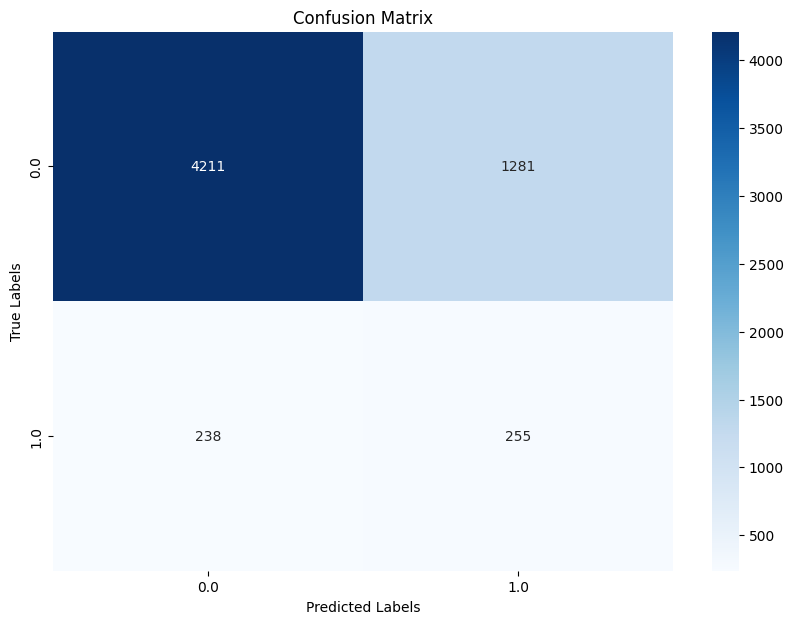

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns 
# Plot the Confusion Matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [27]:
svm_model

SVC(class_weight='balanced', kernel='poly', random_state=42)

In [28]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(svm_model, X_test_processed.toarray(), y_test, n_repeats=30, random_state=42)


KeyboardInterrupt: 

                             Feature  Importance
1                num__KMeans_Cluster    0.022646
0                       num__ranking    0.014308
6         cat__position_group_o_line    0.010209
7   cat__position_group_pass_catcher    0.004745
8             cat__position_group_qb    0.002690
5     cat__position_group_linebacker    0.002668
9   cat__position_group_running_back    0.001905
10       cat__position_group_special    0.001337
2        cat__position_group_athlete    0.000902
4         cat__position_group_d_line   -0.000362
3    cat__position_group_d_backfield   -0.005976


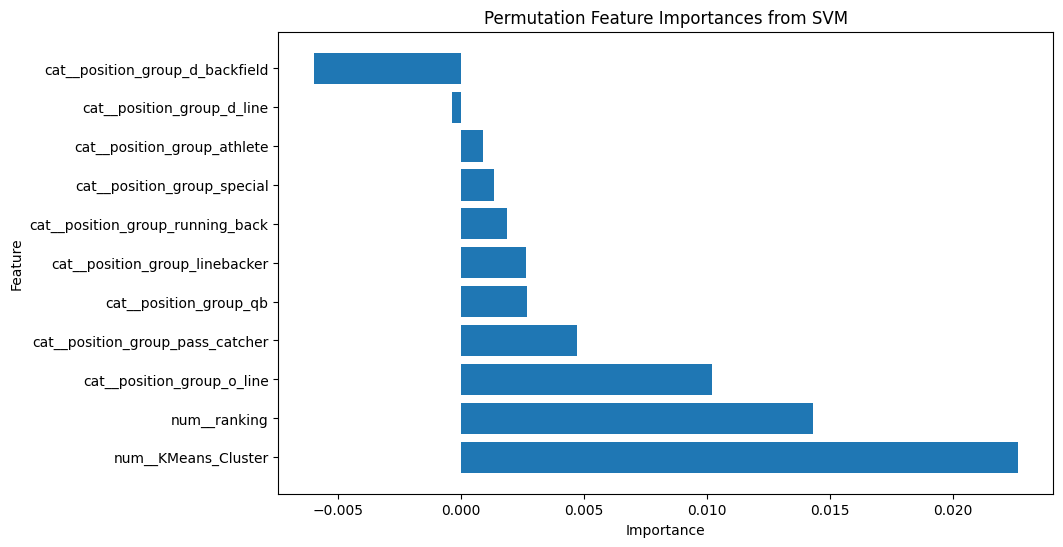

In [33]:

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': preprocessor.get_feature_names_out(), 'Importance': perm_importance.importances_mean})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importances from SVM')
plt.show()